In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import matplotlib.pyplot as plt


Scraping tickers in S&P500 

In [2]:
# URL of Yahoo Finance's S&P 500 components
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add a header to look like a normal browser
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

# Request the page
response = requests.get(url, headers=headers)
response.raise_for_status()

# Parse the table from the HTML
tables = pd.read_html(response.text)
sp500_table = tables[0]

# Clean ticker symbols (replace '.' with '-' for Yahoo format)
sp500_table["Symbol"] = sp500_table["Symbol"].str.replace(".", "-", regex=False)

tickers = sp500_table["Symbol"].tolist()

print("✅ Retrieved", len(tickers), "tickers.")

✅ Retrieved 503 tickers.


C:\Users\hc200\AppData\Local\Temp\ipykernel_9264\1890805331.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Downloading stock close prices

In [3]:
close_df = yf.download(tickers, threads=True, start = '2023-01-01')['Close']
pd.to_datetime(close_df.index)
close_df = close_df.ffill()
close_df.head(3)

C:\Users\hc200\AppData\Local\Temp\ipykernel_9264\1125923714.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close_df = yf.download(tickers, threads=True, start = '2023-01-01')['Close']
[*********************100%***********************]  503 of 503 completed


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,147.012177,123.330643,145.483826,84.900002,103.370216,59.393120,258.138855,336.920013,154.756577,82.079918,...,27.814985,83.384621,63.671192,96.910614,107.169701,64.639999,120.430847,124.327255,260.200012,142.205658
2023-01-04,148.609299,124.602699,146.657516,88.720001,104.907837,59.687901,257.260193,341.410004,158.052704,79.095192,...,28.148478,88.537109,64.216400,97.192650,107.005219,66.300003,122.062386,125.479889,262.989990,144.248917
2023-01-05,149.040451,123.281326,146.478317,87.709999,104.521072,59.849552,251.185425,328.440002,152.127258,77.117584,...,27.310240,88.965668,62.916988,99.367264,103.966995,64.709999,121.132782,123.155098,260.059998,140.849945


Filtering stocks

In [4]:
def filter_stocks(df):
    valid_stocks = pd.DataFrame()    
    for col in df.columns:
        momentum = df[col].pct_change(periods = 5).mean()
        volatility = df[col].pct_change(periods = 5).std()
        avg_volume = df[col].rolling(window = 5).mean()
        if (momentum > 0.02)and (volatility < 0.02) and (avg_volume > 1000000):
            valid_stocks[col] = df[col].copy()

    print("✅ Found", len(valid_stocks.columns), "valid stocks.")
    valid_stocks.head(3)
        


Signal Generator 

In [5]:
def signal_generator(ticker):
    # Moving Averages
    fast_MA = ticker.rolling(window=20, min_periods=1).mean() #returns a series, with min 1 value to avoid NaN
    slow_MA = ticker.rolling(window=60, min_periods=1).mean()

    # MACD
    fast_EMA = ticker.ewm(span=12, adjust=False, min_periods=1).mean()
    slow_EMA = ticker.ewm(span=26, adjust=False, min_periods=1).mean()
    MACD = fast_EMA - slow_EMA

    # Momentum & Volatility
    momentum = ticker.pct_change(periods=5)
    volatility = ticker.pct_change(periods=5).rolling(window=5).std()

    # Conditions
    buy_signal = (fast_MA > slow_MA) & (MACD > 0) & (momentum > 0.02) & (volatility < 0.02)
    sell_signal = (fast_MA < slow_MA) & (MACD < 0) & (momentum < -0.02) & (volatility > 0.02)

    # Output signals
    signal = pd.Series(0, index=ticker.index)
    signal[buy_signal] = 1
    signal[sell_signal] = 0

    return signal
    



In [6]:
signal_matrix = pd.DataFrame(0, index = close_df.index, columns = close_df.columns)
for col in close_df.columns:
    # signal_matrix[col] = close_df[col].apply(signal_generator) This won't work as signal_generator expects a Series, not a single value
    signal_matrix[col] = signal_generator(close_df[col])
        
# Check aggregated signals       
stacked = signal_matrix.stack().reset_index()
stacked.columns = ['Date', 'Ticker', 'signal']
# check = stacked.groupby('Ticker')['signal'].value_counts()
signal_matrix = stacked.pivot(index='Date', columns='Ticker', values='signal')




Calculating returns 

In [7]:
return_df = close_df.pct_change().fillna(0)
return_df = return_df
return_df = return_df.shift(1)*signal_matrix
return_df.fillna(0, inplace=True)
    
            

Generate Portfolio Returns

In [15]:
# Results based on if we have equal weight allocation among all selected stocks
positions = signal_matrix.copy()

# Mask returns so only active positions contribute
masked_returns = return_df * positions.shift(1)

# Count how many positions are active each day
active_pos = positions.shift(1).sum(axis=1)

# Equal-weighted daily portfolio return
portfolio_df = pd.DataFrame(index=return_df.index)
portfolio_df['returns'] = masked_returns.sum(axis=1).div(len(masked_returns.columns)).fillna(0)

# Check summary
print(portfolio_df['returns'].describe())

count    713.000000
mean       0.000337
std        0.000438
min       -0.001002
25%        0.000046
50%        0.000217
75%        0.000473
max        0.003623
Name: returns, dtype: float64


Plot Results against S&P500

C:\Users\hc200\AppData\Local\Temp\ipykernel_9264\2205458134.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("^GSPC", start=return_df.index.min(), end=return_df.index.max())
[*********************100%***********************]  1 of 1 completed

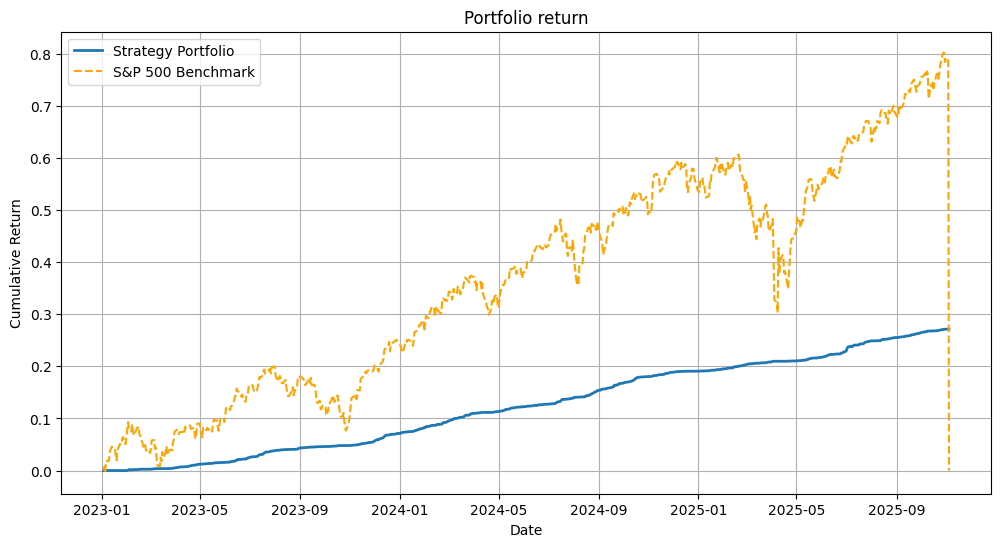

In [ ]:
spy = yf.download("^GSPC", start=return_df.index.min(), end=return_df.index.max())
benchmark = spy['Close'].pct_change().fillna(0)

#  Obtain cumulative returns
portfolio_cum = (1 + portfolio_df['returns']).cumprod() - 1
benchmark_cum = (1 + benchmark).cumprod() - 1
benchmark_cum = benchmark_cum.reindex(portfolio_cum.index).fillna(0)

total = pd.DataFrame(index=portfolio_cum.index)
total['Portfolio'] = portfolio_cum
total['Benchmark'] = benchmark_cum
total.fillna(0, inplace=True)

plt.figure(figsize=(12,6))
plt.plot(total.index, total['Portfolio'], label='Strategy Portfolio', linewidth=2)
plt.plot(total.index, total['Benchmark'], label='S&P 500 Benchmark', linestyle='--', color='orange')
plt.title('Portfolio return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()